Apply LDA to classify spectral embeddings:
    
    Tools: scikit-learn 0.24.1


##  LDA

In [1]:
import os
from matplotlib import pyplot as plt
import pickle
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
import pandas as pd

## Define functions

In [35]:
def define_data(X_embedding, y_label_list, min_group_size=1, remove_unclassified = True):
    y_label = np.array(y_label_list)
    # Kick out the unexpected groups     
    lbs = Counter(y_label)
    lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
    sel_index=[]
    for i,v in enumerate(list(lbs.values())):
        if v >= min_group_size:
            sel_index.append(i)
    select_lbs = [list(lbs.keys())[i] for i in sel_index]   
    if remove_unclassified == True:
        if 'Unclassified' in select_lbs:
            select_lbs.remove('Unclassified')           
    print(str(len(select_lbs))+' groups were selected.')    
    # Connect the selected groups to embeddings
    select_index = []
    for i in select_lbs:
        temp_index, = np.where(y_label==i)
        #print(temp_index)
        select_index += list(temp_index)
    select_index.sort()
    #print(select_index)
    y_label_2 = np.array(y_label[select_index])
    print(y_label_2.shape)
    X_embedding_2=X_embedding[select_index,:]
    print(X_embedding_2.shape)
    return X_embedding_2, y_label_2


def perform_lda(X_embedding, y_label, testing_size = 0.25, stratification=True):
    # Split the dataset into the Training set and Test set
    if stratification == True:
        X_train, X_test, y_train, y_test = train_test_split(X_embedding, y_label, test_size = testing_size, random_state = 0, stratify=y_label)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_embedding, y_label, test_size = testing_size, random_state = 0)
        
    # Apply Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Apply LDA
    t0=time.process_time()
    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_train,y_train)
    t1=time.process_time()-t0
    print('Time elapsed: %.3f' % t1)

    # Predict the test set results and check the accuracy
    y_pred = lda_model.predict(X_test)
    accuracy_lda = accuracy_score(y_test,y_pred)
    print('Accuracy: %.3f' % accuracy_lda)

    labels =list(np.unique(np.array(list(y_test)+list(y_pred))))
    conf_mat = confusion_matrix(y_test,y_pred, labels = labels)
    print(conf_mat)
    return conf_mat,y_test,y_train,y_pred,labels


def plot_confusion_matrix(confusion_mat, labels, save_path):    
    # Plot Confusion matrix  # Ignore: this plot is too large to plot.
    if len(labels) >= 10:
        a = len(labels)//5+5;
    else:
        a = 5
    #plt.figure(figsize = (a,a*4//5))
    #ax= plt.subplot()
    df_cm = pd.DataFrame(confusion_mat, columns=np.unique(labels), index = np.unique(labels))
    df_cm.to_pickle(save_path+'.pkl')
    #df_cm.index.name = 'Actual labels'
    #df_cm.columns.name = 'Predicted labels'
    #sns.set(font_scale=1.8)
    #sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d',annot_kws={"size": 10})
    #plt.savefig(save_path+'.svg',dpi=300,bbox_inches='tight')
    return df_cm
  
    
def calculate_accuracy_per_label(label, conf_matrix, y_train, save_path):
    accuracy = []
    group_size_pred=[]
    group_size_test=[]
    group_size_train=[]
    group_size = []
    predict_vs_test_size=[]
    group_size_train_dict = {k:list(y_train).count(k) for k in label}
    for i in range(len(label)):
        if label[i] != 'Unclassified':
            true_result = conf_matrix[i,i]
            all_result_pred = np.sum(conf_matrix,axis=0)[i]
            group_size_pred.append(all_result_pred)
            all_result_test = np.sum(conf_matrix,axis=1)[i]
            #print(all_result_pred, all_result_test)
            group_size_test.append(all_result_test)
            group_size_train.append(group_size_train_dict[label[i]])
            group_size.append(all_result_test+group_size_train_dict[label[i]])

            if all_result_pred == 0:
                accuracy.append(0)
            else:
                accuracy.append(true_result/all_result_pred)

            if all_result_test == 0:
                predict_vs_test_size.append(all_result_pred+1)
            else:
                predict_vs_test_size.append(all_result_pred/all_result_test)
    if 'Unclassified' in label:
        print('Removing Unclassified groups')
        label.remove('Unclassified')
    accuracy_dict = {'labels':label, 'accuracy':accuracy,'predict_vs_test_size': predict_vs_test_size,'group_size': group_size,
                     'group_size_pred':group_size_pred, 'group_size_test':group_size_test, 'group_size_train':group_size_train}
    with open(save_path, 'wb') as f:
        pickle.dump(accuracy_dict, f)
    return accuracy_dict


def scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x, x_label, datatype, save_dir):
    x= accuracy_dict[x_label]
    y= accuracy_dict['accuracy']
    plt.rcParams.update({'figure.figsize':(10,7)})
    plt.scatter(x, y)

    plt.title('Accuracy of predicted results vs. %s in %s' % (x_label, datatype))
    plt.xlabel(x_label)
    plt.ylabel('Accuracy per group')
    for i,txt in enumerate(accuracy_dict['labels']):
        if x[i] >= show_annot_min_x:
            plt.annotate(txt,(x[i],y[i]), fontsize=10)
    plt.savefig(save_dir+'plot_accuracy_vs'+x_label+'_'+datatype+'.svg',dpi = 100, bbox_inches='tight')
    plt.show()
    

    

## Loading array from files

In [3]:
## Loading embedding arrays
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv') as file_name:
    X_embedding = np.loadtxt(file_name, delimiter=",")
print(X_embedding.shape)

(16360, 300)


## LDA for ClassyFire all data

### Class level in ClassyFire

(16360,)
183 groups were selected.
(15034,)
(15034, 300)
Time elapsed: 2.065
Accuracy: 0.351
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]


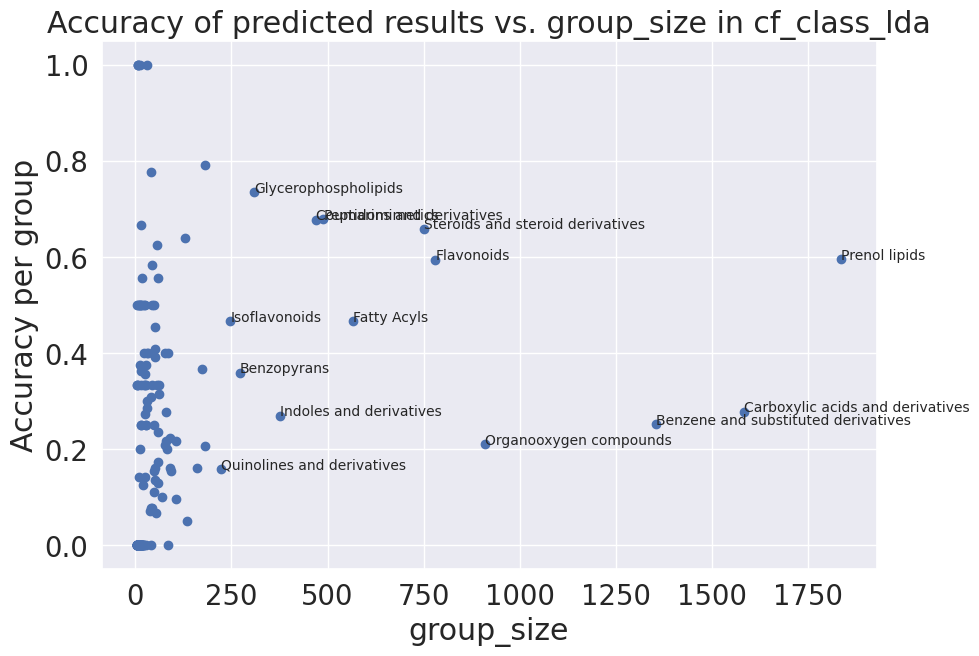

In [39]:
## Loading class labels
data_type='cf_class_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_class_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

### Superclass level in ClassyFire

(16360,)
17 groups were selected.
(15261,)
(15261, 300)
Time elapsed: 1.137
Accuracy: 0.498
[[ 79  11   0   1   0   0   7   0   0  14   1   1  42   0   0   1  12]
 [  9 169   1   0   0  10  25   4   0  35   3   7 147   0   1   4  64]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0   1]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0]
 [  3   4   0   0   0  12   1   1   0   2   0   0   8   0   0   0   7]
 [  5  51   0   0   2   8 621   7   0  54   9  34  81   2   0   3  64]
 [  1   5   0   0   0   0   2  12   0   4   0   1  12   0   0   0   2]
 [  0   1   0   0   0   0   0   0   7   4   0   0   1   0   0   0   0]
 [  2  51   1   0   0   1  52   3  16 283   5  15  88   0   1   5  30]
 [  0  14   0   0   0   0   7   1   0   3   4   0  14   0   0   0   2]
 [  2  27   0   0   0   3  25   3   2  28   4  44  41   1   0   2  46]
 [ 34 103   0   0   0   4  60   6   0  61   4  11 320   

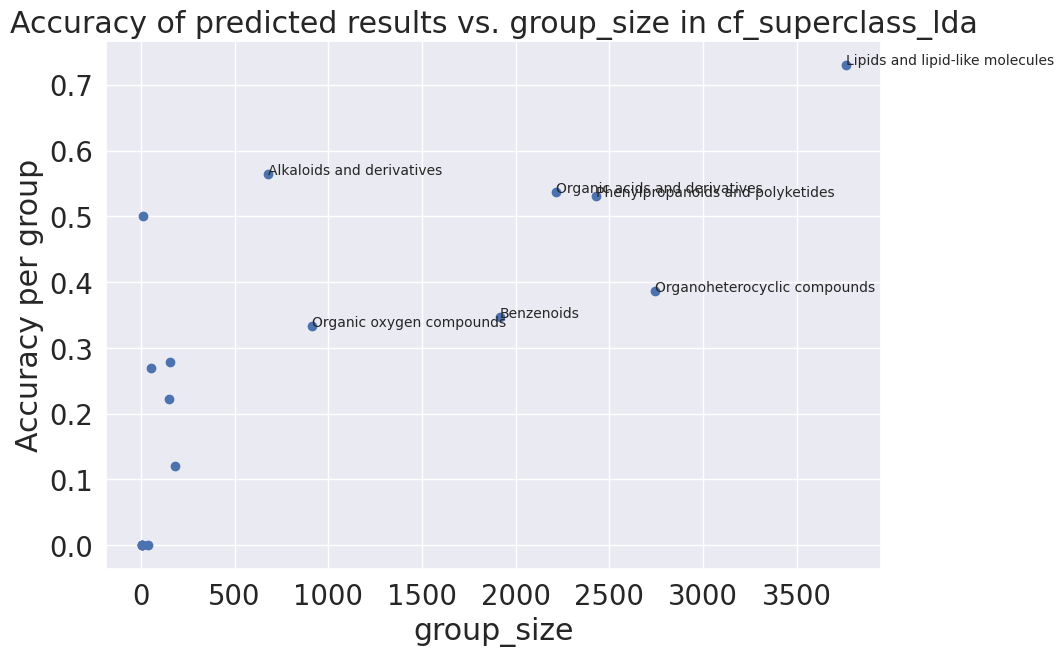

In [42]:
## Loading class labels
data_type='cf_superclass_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_superclass_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Sublass level in ClassyFire

(16360,)
288 groups were selected.
(12552,)
(12552, 300)
Time elapsed: 2.078
Accuracy: 0.334
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


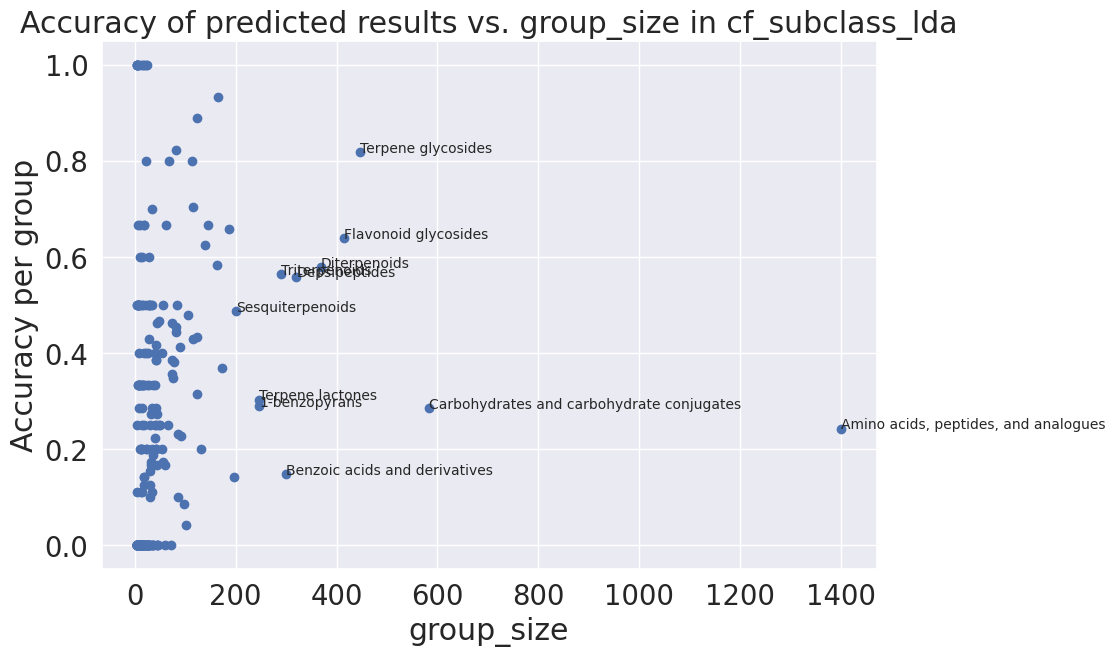

In [43]:
## Loading class labels
data_type='cf_subclass_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_subclass_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Class in NPClassifier

(16360,)
309 groups were selected.
(12816,)
(12816, 300)
Time elapsed: 2.406
Accuracy: 0.367
[[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


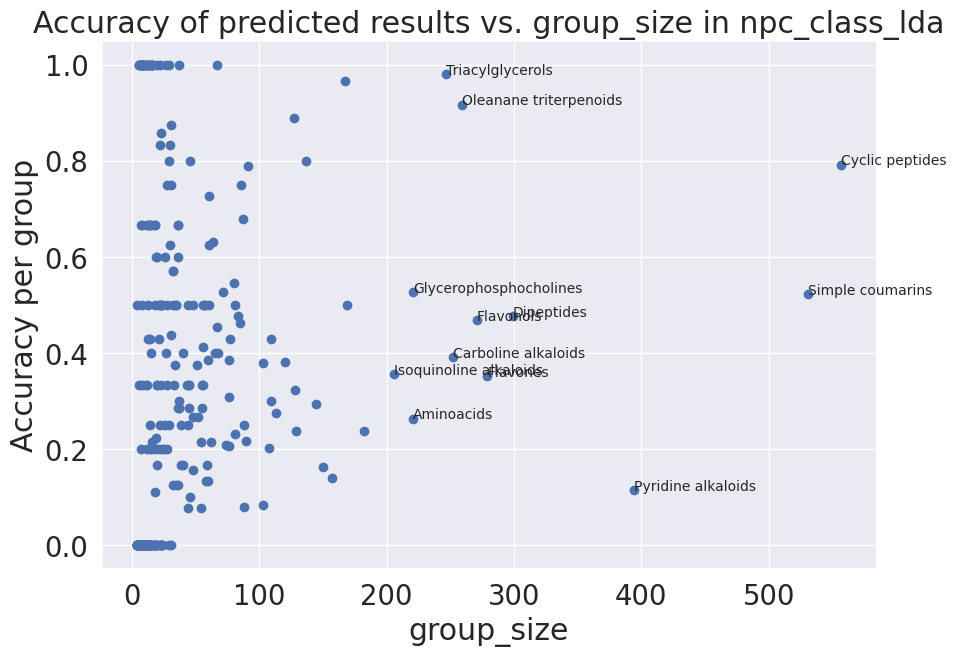

In [44]:
data_type='npc_class_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_class_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

### Superclass in NPClassifier

(16360,)
64 groups were selected.
(13491,)
(13491, 300)
Time elapsed: 1.198
Accuracy: 0.466
[[ 0  0  0 ...  1  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0 19 ...  2  0  1]
 ...
 [ 0  0  4 ... 55  1  1]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  1 ...  0  0  6]]


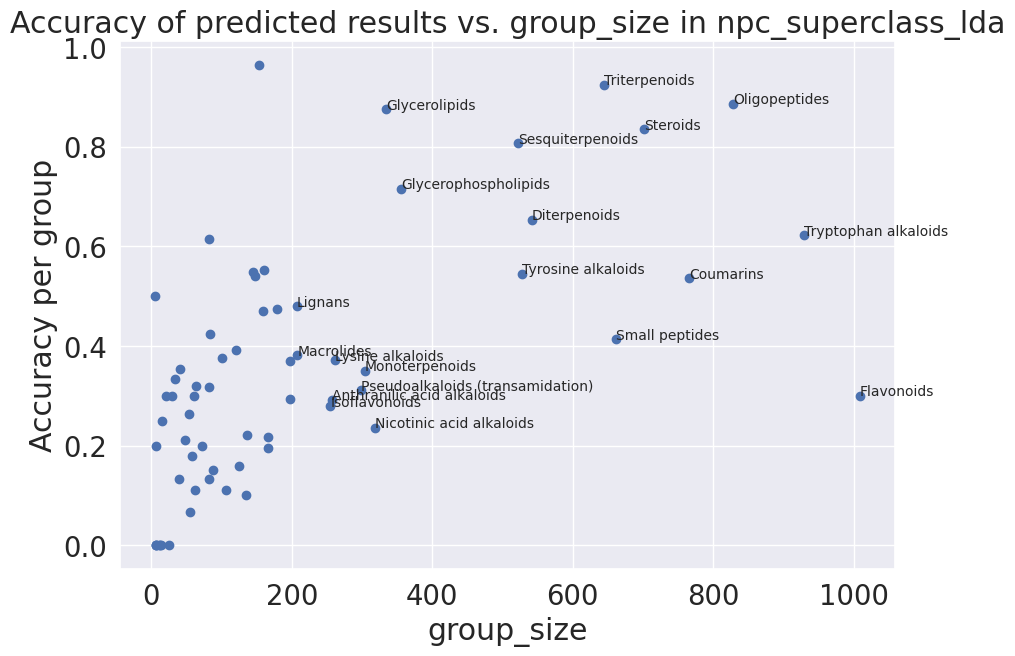

In [45]:
data_type='npc_superclass_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_superclass_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

### Pathway in NPClassifier

(16360,)
7 groups were selected.
(15268,)
(15268, 300)
Time elapsed: 4.693
Accuracy: 0.621
[[866  26  12  15   8  89  19]
 [149 214  10  14   5  31   9]
 [ 37   1  47   3   1   7   4]
 [103   9   9 209  13  26  24]
 [ 89   7   6  11  61 111  36]
 [171  12   7   8  43 509  18]
 [129  16   7  27  32  91 466]]


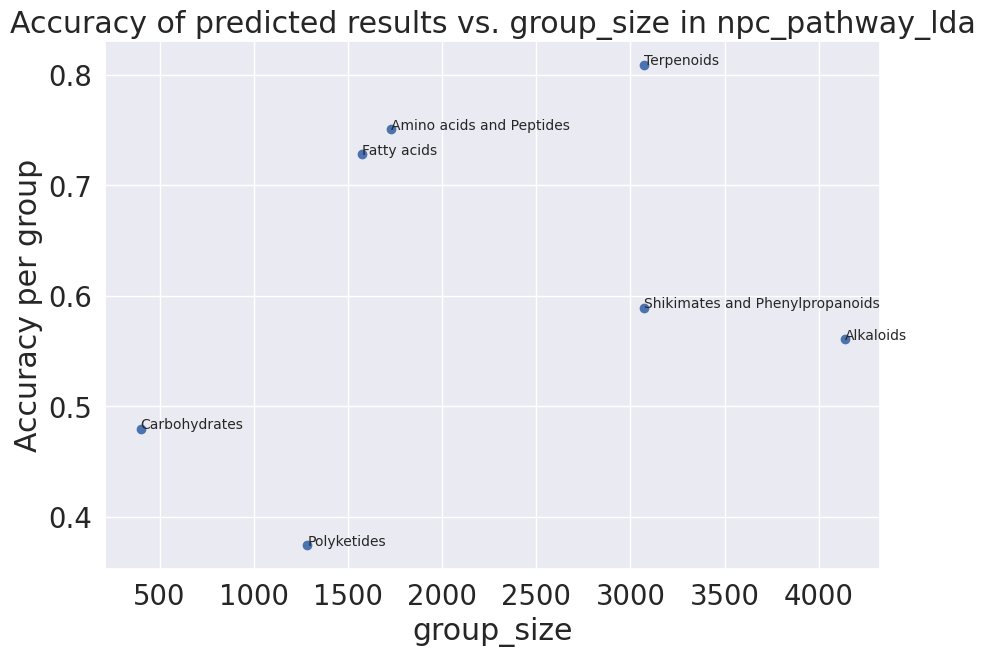

In [46]:
data_type='npc_pathway_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_pathway_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)